# Airbnb Data Analytics

In our previous post, we have wrote on how to connect to MySQL Server and insert you data into the database. In this article, we will explore the data using SQL query in python.

The following is the list of libraries that we will use throughout the notebook.

In [2]:
# Data wrangling
import pandas as pd
import numpy as np
import re

# Connect MySQL
import mysql.connector

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Draw map
import folium
import folium.plugins

%matplotlib inline

# Connect to MySQL Server

Let's first connect to the MySQL Server that we have set up previously.

In [3]:
mydb = mysql.connector.connect(
    host = "db4free.net",
    port = 3306,
    user = "your_name",
    password = "your_name",
    database = "your_database"
)

print(mydb)

Let's check the available table in our database.

In [4]:
pd.read_sql("SHOW TABLES", mydb)

Tables_in_db_zeed
0         host_info
1           listing

We currently have 2 different tables with the following properties:

- `listing`: Information about room listing of Airbnb in Bangkok, Thailand
- `host_info`: Information about host of Airbnb in Bangkok, Thailand

# Research Question

It's better for us to define what kind of insight that we want to draw from the database. Here, I define my research questions. These questions just to give you the illustration on how to do data analysis, so they may not deep enough to give any recommendation. You can come up with your questions as well.

## Room Listing

- What is the most common room type available?
- What is the top and bottom 10 property type based on average price?
- What is the top and bottom 10 property type based on review score?
- What is the most common amenities provided?
- Is there any correlation between room price and the review score?
- Room listing geographical distribution

## Host

- Who are the top 10 host based on revenue?
- Is there any difference in review score between superhost and normal host?
- Is there any difference in response rate between superhost and normal host?
- What is the most commonly verified host information?

# Room Listing

## Common Room Type

Let's start with our first question, what is the most common room type and property type available? We can acquire this information from the `listing` table.

First, let's check how many room listing we have.

In [5]:
pd.read_sql("SELECT COUNT(*) as frequency FROM listing", mydb)

frequency
0      19289

Now let's check the number of data for each *Room type*.

We can use the `COUNT(*)` to count the number of rows and use `GROUP BY` to group the data based on the room type. To get the top 15, we need to arrange the data by using `ORDER BY` and set the sorting to descending (from largest to smallest) using the `DESC`. 

In [6]:
query = """
SELECT room_type, COUNT(*) as frequency
FROM listing
GROUP BY room_type
ORDER BY COUNT(*) DESC
"""

df_query = pd.read_sql(query,mydb)
df_query

room_type  frequency
0  Entire home/apt      10534
1     Private room       7014
2       Hotel room       1014
3      Shared room        727

Let's create a simple bar chart to visualize this result.

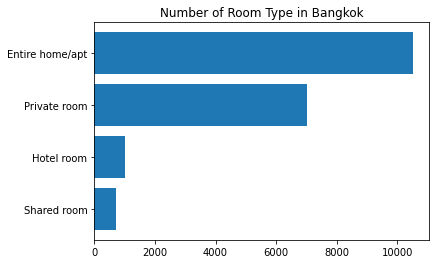

In [7]:
df_query = df_query.sort_values(['frequency'])

plt.barh(df_query.room_type, df_query.frequency)
plt.title("Number of Room Type in Bangkok")
plt.show()

The most common listing available is either entire home or apartment, followed by private room. Some hotels are also listing their room in Airbnb apparently.

## Common Property Type

Let's get the top 15 property type from the data. Property type is the more granular and more detailed version from the room type.

We can use the `COUNT(*)` to count the number of rows and use `GROUP BY` to group the data based on the property type. To get the top 15, we need to arrange the data by using `ORDER BY` and set the sorting to descending (from largest to smallest) using the `DESC`. Finally, we limit the data to take only the first 15 row using the `LIMIT`.

In [8]:
query = """
SELECT property_type, COUNT(*) as frequency
FROM listing
GROUP BY property_type
ORDER BY COUNT(*) DESC
LIMIT 15
"""

df_query = pd.read_sql(query,mydb)
df_query

property_type  frequency
0                    Entire apartment       5102
1                  Entire condominium       3679
2           Private room in apartment       2057
3         Private room in condominium        971
4               Private room in house        767
5              Room in boutique hotel        692
6                       Room in hotel        574
7           Private room in townhouse        573
8              Private room in hostel        573
9                        Entire house        491
10          Entire serviced apartment        469
11              Shared room in hostel        411
12  Private room in bed and breakfast        350
13                   Entire townhouse        349
14                     Room in hostel        307

Let's create a simple bar chart to visualize this result.

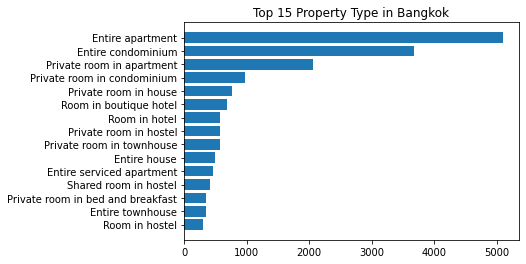

In [9]:
df_query = df_query.sort_values(['frequency'])

plt.barh(df_query.property_type, df_query.frequency)
plt.title("Top 15 Property Type in Bangkok")
plt.show()

## Property Type by Average Price

Does apartment and condominium become popular choice because they are the cheapest option out there for the host to offer? To answer this question, let's check the top 10 and bottom 10 property type based on the average price for a property type with at least 50 different listing. 

In [10]:
# Top 10 Property Based on Price
query = """
SELECT property_type, average_price, frequency
FROM 
    (SELECT property_type, AVG(price) as average_price, COUNT(*) as frequency
        FROM listing
        GROUP BY property_type
    ) as new_table
WHERE frequency >= 50
ORDER BY average_price DESC
LIMIT 10
"""

df_top10 = pd.read_sql(query, mydb)

# Bottom 10 Property Based on Price
query = """
SELECT property_type, average_price, frequency
FROM 
    (SELECT property_type, AVG(price) as average_price, COUNT(*) as frequency
        FROM listing
        GROUP BY property_type
    ) as new_table
WHERE frequency >= 50
ORDER BY average_price
LIMIT 10
"""

df_bottom10 = pd.read_sql(query, mydb)

# Bind row the dataframe
df_price_rank = pd.concat([df_top10, df_bottom10], axis = 0)

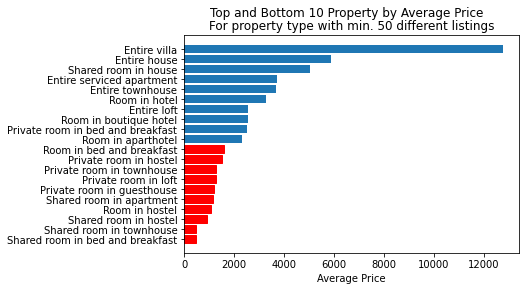

In [11]:
# Sort data by average price
df_price_rank.sort_values('average_price', inplace = True)

# Visualization
bar_chart = plt.barh(df_price_rank.property_type, df_price_rank.average_price)
plt.suptitle("Top and Bottom 10 Property by Average Price")
plt.title("For property type with min. 50 different listings")
plt.xlabel("Average Price")

# Give different color for bottom 10
for i in range(0,10):
    bar_chart[i].set_color('red')

plt.show()

The most expensive property that is being listed is the entire villa, followed by entire house. Surprisingly, shared room in house has higher average price compared to other property. Meanwhile, on the bottom 10 the list is dominated by listing for private and shared room. However, we don't see listing for private room or entire apartment/condominium in the top and bottom 10, so we may conclude that the price for those listings is somewhere in the middle.

## Property Type by Review Score

According to [Airbnb](https://www.airbnb.com/help/article/1257/star-ratings), there are several star ratings available for the user to measure how good the service given by the listing. Several rating that we can use including:

- **Overall experience**: How was it?
- **Cleanliness**: Did the place meet our standards?
- **Accuracy**: Was it accurately represented with up-to-date photos and info?
- **Check-in**: Should be easy
- **Communication**: Did the Host respond to messages promptly?
- **Location**: Was the guest made aware of safety, transportation, points of interest and special considerations like noise or other situations that might affect their stay?
- **Value**: Was it worth the price?

First, let's check if there are significant difference in average of rating of the overall experience for certain property type. Some listing may don't have any rating yet, so we will filter data that has non-NULL rating and select only property type with at least 50 different listing.

In [12]:
# Top 10 Property Based on Review Score
query = """
SELECT property_type, average_score, frequency
FROM 
    (SELECT property_type, AVG(review_scores_rating) as average_score, COUNT(*) as frequency
        FROM listing
        WHERE review_scores_rating IS NOT NULL
        GROUP BY property_type
    ) as new_table
WHERE frequency >= 50
ORDER BY average_score DESC
LIMIT 10
"""

df_top10 = pd.read_sql(query, mydb)

# Bottom 10 Property Based on Review Score
query = """
SELECT property_type, average_score, frequency
FROM 
    (SELECT property_type, AVG(review_scores_rating) as average_score, COUNT(*) as frequency
        FROM listing
        WHERE review_scores_rating IS NOT NULL
        GROUP BY property_type
    ) as new_table
WHERE frequency >= 50
ORDER BY average_score
LIMIT 10
"""

df_bottom10 = pd.read_sql(query, mydb)

# Bind row the dataframe
df_score_rank = pd.concat([df_top10, df_bottom10], axis = 0)

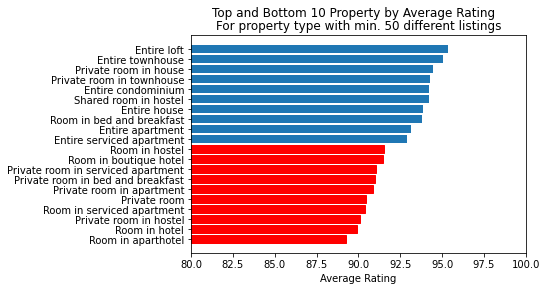

In [13]:
# Sort data by average price
df_score_rank.sort_values('average_score', inplace = True)

# Visualization
bar_chart = plt.barh(df_score_rank.property_type, df_score_rank.average_score)
plt.suptitle("Top and Bottom 10 Property by Average Rating")
plt.title("For property type with min. 50 different listings")
plt.xlabel("Average Rating")
plt.xlim([80, 100])

# Give different color for bottom 10
for i in range(0,10):
    bar_chart[i].set_color('red')

plt.show()

`Entire loft` and `Entire townhouse` become the top listings with the highest overall experience, reflected by the average review scores rating. `Entire apartment` and `Entire condominium` are also present as well as the top 10 overall experience. The listings with the least overall experience belong to `Room in aparthotel` and `Room in hotel`. Despite being one of the most expensive listing, people generally have lower overall experience rating for `Room in hotel` compared to other listing.

## Correlation Between Price and Overall Experience

Let's check whether listing with higher price will give higher overall experience as well using simple scatterplot. We will scale the listing price to log10 units. We only collect listing with non-NULL value for the review scores rating. We will also filter the data by collecting listing that has more than 10 number of reviews.

In [14]:
# Collect Required Columns
query = """
SELECT price, review_scores_rating
FROM listing
WHERE review_scores_rating IS NOT NULL AND number_of_reviews > 10
"""

df_query = pd.read_sql(query, mydb)

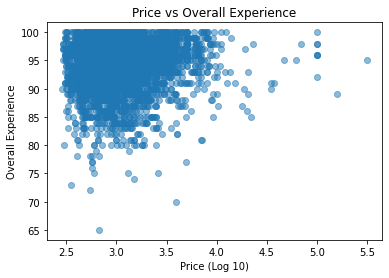

In [15]:
plt.scatter( np.log10(df_query.price), df_query.review_scores_rating, alpha = 0.5)
plt.xlabel("Price (Log 10)")
plt.ylabel("Overall Experience")
plt.title("Price vs Overall Experience")

plt.show()

Most of the listing room has price higher than 300 bhat (2.5 in log10 scale), but there is one room that has price lower than 300 bhat and has high review scores rating. Based on the distribution, no listing room has overall experience lower than 80 for listing room with price higher than 10,000 bhat (4 in log10 scale). For price ranging from 300 bhat to 10,000 bhat, there is no correlation between price and overall experience. However, as the price goes up, people tend to be give higher rating. 

## Amenities 

Let's continue by checking the most common amenities that is included for the given service.

In [16]:
query = """
SELECT amenities, review_scores_rating, price
FROM listing
"""

df_query = pd.read_sql(query, mydb)
df_query.head()

amenities  review_scores_rating  \
0  Microwave, Pool, Smoke alarm, Dryer, Long term...                  97.0   
1  Cable TV, Kitchen, Air conditioning, Free park...                   NaN   
2  Cable TV, TV, Pool, Shampoo, Hot tub, Heating,...                   NaN   
3  Dedicated workspace, Air conditioning, Hair dr...                  96.0   
4                            Long term stays allowed                   NaN   

    price  
0  1694.0  
1   924.0  
2  1188.0  
3  1095.0  
4   800.0

The amenities is still in a long string format. To process this data, we will split the string into individual amenities indicated by the comma.

In [17]:
df_query.amenities[0]

'Microwave, Pool, Smoke alarm, Dryer, Long term stays allowed, Hair dryer, Stove, Iron, Free parking on premises, Essentials, Dishes and silverware, Washer, Hot water, Patio or balcony, Hangers, Air conditioning, Luggage dropoff allowed, Kitchen, Gym, Fire extinguisher, Elevator, TV, Dedicated workspace, Host greets you, Shampoo, Wifi, Refrigerator'

To prevent the possibility of mistyping or other free text error, we will convert all alphabets into lowercase.

In [18]:
df_query.amenities = list(map(lambda x: x.lower(), df_query.amenities))

df_query.amenities[0]

'microwave, pool, smoke alarm, dryer, long term stays allowed, hair dryer, stove, iron, free parking on premises, essentials, dishes and silverware, washer, hot water, patio or balcony, hangers, air conditioning, luggage dropoff allowed, kitchen, gym, fire extinguisher, elevator, tv, dedicated workspace, host greets you, shampoo, wifi, refrigerator'

Let's start collecting all amenities.

In [19]:
list_amenities = []
for i in range(df_query.shape[0]):
    
    amenities_i = df_query.amenities[i].split(", ")
    list_amenities.extend(amenities_i)

df_amenities = pd.DataFrame(list_amenities, columns= {"amenities"})

After all amenities are collected, it's time to create a dataframe that consists of the amenities and it's respective frequency. We will normalize the frequency into percentage to reflect of all listing available, what percentage of listing use the mentioned amenities.

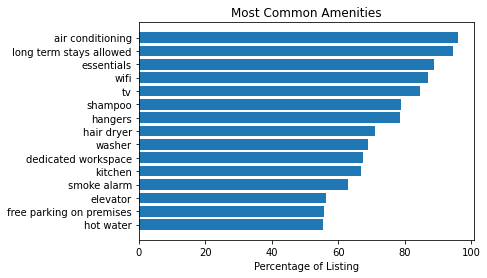

In [20]:
# Create frequency dataframe
df_viz = pd.DataFrame(df_amenities.value_counts('amenities'))
df_viz.reset_index(inplace = True)
df_viz.rename(columns = {0:"freq"}, inplace = True)

# Create ratio column
df_viz['ratio'] = df_viz.freq/df_query.shape[0]*100

# Get and sort the first 15 rows
df_viz = df_viz.head(15)
df_viz.sort_values('ratio', inplace = True)

# Visualization
plt.barh(df_viz.amenities, df_viz.ratio)
plt.xlabel("Percentage of Listing")
plt.title("Most Common Amenities")

plt.show()

Almost all of the available listing has `Air conditioning` and `Long term stays allowed`, followed by `Essentials`, `Wifi`, and `TV`. More than 60% of all listing also has `Dedicated workspace` and `Kitchen`, which may require more spaces outside the bedroom. According to [Airbnb](https://www.airbnb.com/help/article/2343/what-are-essential-amenities), essentials amenities including:

- Toilet paper
- Soap (for hands and body)
- One towel per guest
- One pillow per guest
- Linens for each guest bed

Essential amenities are the basic items that a guest expects in order to have a comfortable stay. So we can check the distribution of the overall experience from listing with and without `Essentials` amenities.

In [21]:
df_viz = df_query[ df_query.review_scores_rating.isna() == False].copy()
df_viz['has_essential'] = df_viz.amenities.str.contains('essentials')

df_viz.head()

amenities  review_scores_rating  \
0   microwave, pool, smoke alarm, dryer, long term...                  97.0   
3   dedicated workspace, air conditioning, hair dr...                  96.0   
6   hangers, shower gel, pool, shampoo, bed linens...                  80.0   
9   cooking basics, free street parking, wifi, ded...                  98.0   
11  cable tv, tv, breakfast, long term stays allow...                 100.0   

     price  has_essential  
0   1694.0           True  
3   1095.0           True  
6    800.0           True  
9    541.0           True  
11  1401.0          False

We will visualize the data using boxplot for each category.

Text(0, 0.5, 'Review Scores Rating')

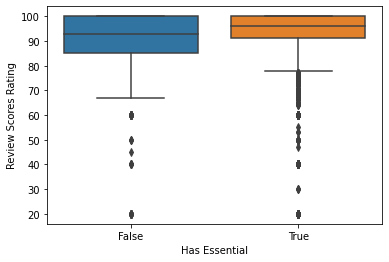

In [22]:
sns.boxplot(x = 'has_essential', y = 'review_scores_rating', data = df_viz)
plt.xlabel("Has Essential")
plt.ylabel("Review Scores Rating")

Listing room that has `Essentials` included in the amenities tend to have slightly higher review scores rating based on the median (the middle line from the box) compared to listing that does not include `Essentials`.

## Listing Map

Let's now draw map and see the distribution of the room listing based on the geopgrahic location using the `folium` package. We may also want to give the information about the name of the host for the popup of the map. Therefore, we need to join our `listing table` with the `host_info` table and get name host name.

In [23]:
query = """
SELECT id, name, listing_url, latitude, longitude, price, review_scores_rating, number_of_reviews, neighbourhood_cleansed, listing.host_id, host_info.host_name
FROM listing
LEFT JOIN host_info
ON listing.host_id = host_info.host_id
"""

df_query = pd.read_sql(query, mydb)
df_query.head()

id                                               name  \
0  27934                    Nice room with superb city view   
1  27942                   Town House (1) bedroom available   
2  27979                     Easy going landlord,easy place   
3  28354  Place near Metro and Shopping Mall ( Monthly o...   
4  28745                  modern-style apartment in Bangkok   

                          listing_url  latitude  longitude   price  \
0  https://www.airbnb.com/rooms/27934  13.76000   100.5427  1694.0   
1  https://www.airbnb.com/rooms/27942  13.73463   100.4754   924.0   
2  https://www.airbnb.com/rooms/27979  13.66818   100.6167  1188.0   
3  https://www.airbnb.com/rooms/28354  13.81152   100.5662  1095.0   
4  https://www.airbnb.com/rooms/28745  13.75232   100.6240   800.0   

   review_scores_rating  number_of_reviews neighbourhood_cleansed  host_id  \
0                  97.0                 65            Ratchathewi   120437   
1                   NaN                  0            Bangkok Yai   120462   
2                   NaN                  0                Bang Na   120541   
3                  96.0                 52             Chatu Chak   121848   
4                   NaN                  0              Bang Kapi   123784   

    host_name  
0      Nuttee  
1      Donald  
2         Emy  
3     Jaruwan  
4  Familyroom

Some listing may not have a host name or even the name for the listing, therefore we will modify the value. We will fill missing value from the host name and name column with the string *No Host Name* and *No Name*.

In [24]:
df_query.fillna({"host_name": "No Host Name", "name": "No Name"}, inplace = True)

Now we will draw the map. We will also create a custom popup where we can put several information for each listing. Since visualizing a large number of marker/listing to the map will take a long time, in this part I restrict to only show the first 5,000 listings.

In [25]:
m = folium.Map(location = [13.736717, 100.523186], # Bangkok coordinate
               tiles = "Stamen Terrain" # Type of map to draw
              )

# Create cluster to prevent clutter and overlap
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

# Check if the review scores rating contain NA
list_review = df_query.review_scores_rating.isna()

for i in range(5000):
    
    # Custom popup 
    if list_review[i] == False:
        popup = folium.Html("<b>"  + df_query.name[i] + "</b><br>" +\
                            "Listing ID: " + str(df_query.id[i]) + "<br>" +\
                            "Host Name: " + df_query.host_name[i] + "<br>" +\
                            "Price: {:,}".format(df_query.price[i]) + "<br>" +\
                            "Review Scores Rating: {:,}".format(df_query.review_scores_rating[i]) +"<br>" +\
                            "Number of Reviews: {:,}".format(df_query.number_of_reviews[i]) +"<br>" +\
                            "<a href=" + df_query.listing_url[i] + "> Click for more info</a>", 
                            script = True)
        popup = folium.Popup(popup, max_width=2650)
    else:
        popup = folium.Html("<b>"  + df_query.name[i] + "</b><br>" +\
                            "Listing ID: " + str(df_query.id[i]) + "<br>" +\
                            "Host Name: " + df_query.host_name[i] + "<br>" +\
                            "Price: {:,}".format(df_query.price[i]) + "<br>" +\
                            "Review Scores Rating: : No Rating Yet"+"<br>" +\
                            "Number of Reviews: {:,}".format(df_query.number_of_reviews[i]) +"<br>" +\
                            "<a href=" + df_query.listing_url[i] + "> Click for more info</a>", 
                            script = True)
        popup = folium.Popup(popup, max_width=2650)        
    
    folium.Marker(location = [df_query.latitude[i], df_query.longitude[i]],
                  popup = popup
                 ).add_to(marker_cluster)

m

# Host

We will continue answering the research question by looking at the host data.

## Top Host by Earning

We will see who is the top host based on the total earning cumulated from his/her listings. We will use the following formula to calculate the total earning:

$$
Total\ earning = \Sigma_{i=1}^n price_i\times number\ of\ reviews_i \times minimum\ nights_i
$$

Notes:

- n: Number of listing for the host
- price: Price of ith listing from the host
- number of reviews: Number of reviews of ith listing
- minimum nights: Minimum night of stay of ith listing

Unfortunately, we don't have the detailed data on the number of stay for each customer, so we will use the minimum nights as the number of stay so what we actually calculate is the minimum total earning. We use the number of reviews as the proxy of number of customers.

In [52]:
query = """
SELECT host_id, host_name, SUM(total_earning) as total_earning, COUNT(*) as number_of_listing, AVG(price) as average_price
FROM
    (SELECT listing.host_id, host_info.host_name, price, number_of_reviews, minimum_nights, 
            price * number_of_reviews * minimum_nights as total_earning
    FROM listing
    LEFT JOIN host_info
    ON listing.host_id = host_info.host_id
    WHERE host_name IS NOT NULL
    ) as new_table
GROUP BY host_id, host_name
ORDER BY SUM(total_earning) DESC
"""

df_query = pd.read_sql(query, mydb)
df_query.head()

host_id  host_name  total_earning  number_of_listing  average_price
0   2129668   Wimonpak    195524436.0                 39     906.948718
1  35082871         Ed    170596856.0                 25    4499.720000
2   4039620      Nadda     68861699.0                  2  187214.000000
3  32398198  Touchapon     58527600.0                  2     760.000000
4   3785867      Julia     43732045.0                  2    3463.500000

Now we will visualize the top host based on the number of listing for the start, see if some hosts has higher number of listing than others.

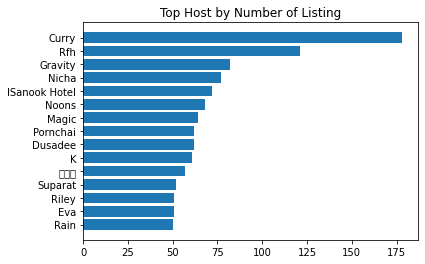

In [54]:
# Get top 15 host by number of listing
df_query.sort_values("number_of_listing", ascending= False, inplace = True)
df_viz = df_query.head(15).copy()

df_viz.sort_values("number_of_listing", inplace = True)

# Visualization
plt.barh(df_viz.host_name, df_viz.number_of_listing)
plt.title("Top Host by Number of Listing")

plt.show()

Only a handful of hosts has more than 5 listings. Now we will continue looking at the top 15 based on the Total Earning generated.

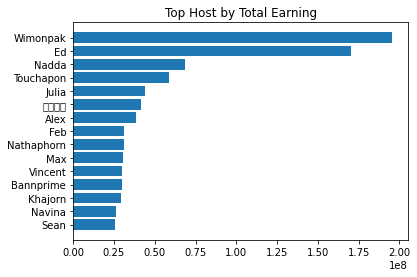

In [56]:
# Get top 15 host by number of listing
df_query.sort_values("total_earning", ascending= False, inplace = True)
df_viz = df_query.head(15).copy()

df_viz.sort_values("total_earning", inplace = True)

# Visualization
plt.barh(df_viz.host_name, df_viz.total_earning)
plt.title("Top Host by Total Earning")

plt.show()

So, the list of host name is different from the top host by the number of listing and the top host by total earning. This indicates that a higher number of listings doesn't guarantee to give more earnings.

Does higher average price of listing from a single host correlate with higher total earning? Let's answer this questions using scatterplot.

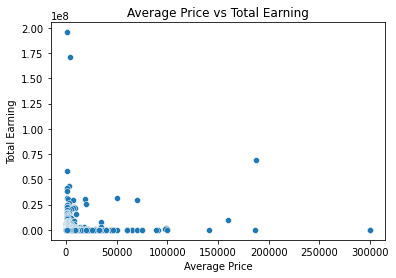

In [57]:
sns.scatterplot(x = 'average_price', y = 'total_earning', data = df_query)
plt.title("Average Price vs Total Earning")
plt.xlabel("Average Price")
plt.ylabel("Total Earning")

plt.show()

As we can see, there is no visible pattern between average price and total earning. However, some of the most highest total earnings are generated by host with relatively low average price from his/her listings. Therefore, higher average price from a host doesn't guarantee to give him/her a higher total earning

## Superhost

According to [Airbnb](https://www.airbnb.com/help/article/828/what-is-a-superhost), superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.

In here we are interested to check if there is any difference in the distribution of review scores for listing owned by a superhost and normal host.

In [30]:
query = """
SELECT review_scores_rating, listing.host_id, host_info.host_name, host_info.host_is_superhost
FROM listing
LEFT JOIN host_info
ON listing.host_id = host_info.host_id
WHERE review_scores_rating IS NOT NULL and host_is_superhost IS NOT NULL
"""

df_query = pd.read_sql(query, mydb)

# Transform superhost as Boolean/Logical
df_query.host_is_superhost = df_query.host_is_superhost.astype('bool')

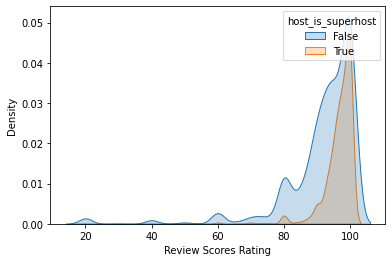

In [42]:
sns.kdeplot(hue = 'host_is_superhost', x = 'review_scores_rating', data = df_query, fill = True)
plt.xlabel("Review Scores Rating")

plt.show()

Both superhost and normal host has the same peak for the distribution, indicating that on average there is no significant difference on review scores rating or the overall experience. However, superhosts has thinner distribution, indicating that superhost tend to have higher review score due to low variability.

Now we will look at the response rate and the acceptance rate between normal host and the superhost. The following is the detail description about response rate and acceptance rate according to [Airbnb](https://www.airbnb.com/resources/hosting-homes/a/understanding-response-rate-and-acceptance-rate-86):

- Your response rate measures how consistently you respond within 24 hours to guest inquiries and booking requests. 
- Your acceptance rate measures how often you accept or decline reservations. Guest inquiries are not included in the calculation of your acceptance rate. 

In [58]:
query = """
SELECT host_id, host_name, host_response_rate, host_acceptance_rate, host_is_superhost
FROM host_info
WHERE host_response_rate IS NOT NULL and host_acceptance_rate IS NOT NULL
"""

df_query = pd.read_sql(query, mydb)
df_query.head()

host_id        host_name host_response_rate host_acceptance_rate  \
0    58920             Gael               100%                 100%   
1   108793            Eddie               100%                 100%   
2   124102  Giacomo & Rolly               100%                  67%   
3   132322  Dasiri Property               100%                  96%   
4   153793           Pemika               100%                 100%   

   host_is_superhost  
0                  0  
1                  1  
2                  0  
3                  0  
4                  1

We need to transform the response rate and acceptance rate to be a proper numeric values by removing the percentage character.

In [44]:
# Transform superhost as Boolean/Logical
df_query.host_is_superhost = df_query.host_is_superhost.astype('bool')

for i in ['host_response_rate', 'host_acceptance_rate']:
    df_query[i] = list(map(lambda x: float(re.sub("[%]", "", x)), df_query[i] ))
    
df_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_id               1605 non-null   int64  
 1   host_name             1605 non-null   object 
 2   host_response_rate    1605 non-null   float64
 3   host_acceptance_rate  1605 non-null   float64
 4   host_is_superhost     1605 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 51.8+ KB


Let's see the distribution of the response rate and acceptance rate.

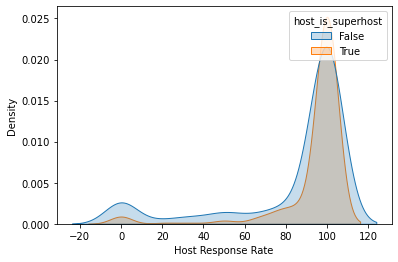

In [45]:
sns.kdeplot(hue = 'host_is_superhost', x = 'host_response_rate', data = df_query, fill = True)
plt.xlabel("Host Response Rate")

plt.show()

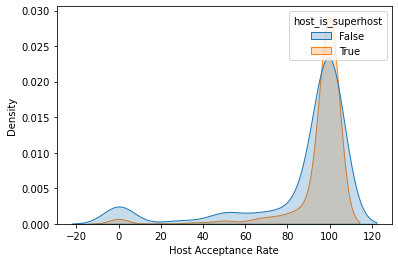

In [46]:
sns.kdeplot(hue = 'host_is_superhost', x = 'host_acceptance_rate', data = df_query, fill = True)
plt.xlabel("Host Acceptance Rate")

plt.show()

Based on plots above, the distribution of response rate and acceptance rate is the same, indicating that there is no signficant difference between a normal host and a superhost.

## Host Verification

When you host on Airbnb, you may be asked to provide information such as your legal name, date of birth, or government ID so it can then be verified. This is a mandatory step for a host to prevent fraud and other financial crimes. Let's deep dive into what kind of informations are mostly filled and verified from a host.

In [59]:
query = """
SELECT host_id, host_name, host_verifications, host_identity_verified
FROM host_info
WHERE host_identity_verified IS NOT NULL
"""

df_query = pd.read_sql(query, mydb)
df_query.host_identity_verified = df_query.host_identity_verified.astype('bool')
df_query

host_id   host_name  \
0         31417        Kami   
1         58920        Gael   
2         70413    Patiyuth   
3        108793       Eddie   
4        120437      Nuttee   
...         ...         ...   
7974  391069620   Chanyarat   
7975  391243930    Jazzotel   
7976  391749044       Pawee   
7977  392902653  Pacharapon   
7978  392928219         Pim   

                                     host_verifications  \
0     email, phone, reviews, jumio, offline_governme...   
1     email, phone, facebook, reviews, offline_gover...   
2                       email, phone, facebook, reviews   
3     email, phone, google, reviews, manual_offline,...   
4     email, phone, reviews, jumio, offline_governme...   
...                                                 ...   
7974                      email, phone, identity_manual   
7975                                              phone   
7976                                       email, phone   
7977                                              phone   
7978                                              phone   

      host_identity_verified  
0                       True  
1                       True  
2                      False  
3                       True  
4                       True  
...                      ...  
7974                    True  
7975                   False  
7976                    True  
7977                    True  
7978                    True  

[7979 rows x 4 columns]

Let's check if there is any host that is not verified yet.

In [60]:
df_query[ df_query.host_identity_verified == False]

host_id   host_name               host_verifications  \
2         70413    Patiyuth  email, phone, facebook, reviews   
5        120462      Donald                     email, phone   
6        120541         Emy                     email, phone   
7        121622    Anchalee  email, phone, facebook, reviews   
9        123784  Familyroom                     email, phone   
...         ...         ...                              ...   
7961  387329237       ไตรทศ                            phone   
7962  387697391       จิรัฐ                     email, phone   
7971  390188200      Thanin                     email, phone   
7972  390727088   อติศักดิ์                            phone   
7975  391243930    Jazzotel                            phone   

      host_identity_verified  
2                      False  
5                      False  
6                      False  
7                      False  
9                      False  
...                      ...  
7961                   False  
7962                   False  
7971                   False  
7972                   False  
7975                   False  

[3946 rows x 4 columns]

There are a lot of host that is yet to be verified. Let's also check if there is any host that has missing value or no host_verification.

In [61]:
df_query[ df_query.host_verifications.isna() ]

Empty DataFrame
Columns: [host_id, host_name, host_verifications, host_identity_verified]
Index: []

Let's check the most commonly verified identity.

In [50]:
# Remove missing verification
df_query = df_query[ df_query.host_verifications.isna() == False]
df_query.reset_index(drop = True, inplace = True)

list_verify = []
for i in range(df_query.shape[0]):
    
    verify_i = df_query.host_verifications[i].split(", ")
    list_verify.extend(verify_i)
    
df_verify = pd.DataFrame(list_verify, columns = {"verified_info"})

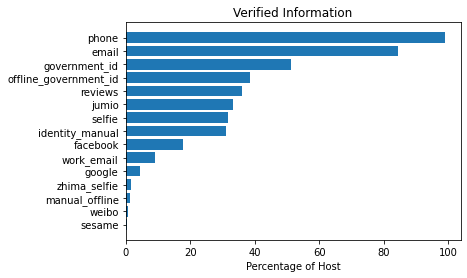

In [51]:
# Create frequency dataframe
df_viz = pd.DataFrame(df_verify.value_counts('verified_info'))
df_viz.reset_index(inplace = True)
df_viz.rename(columns = {0:"freq"}, inplace = True)

# Create ratio column
df_viz['ratio'] = df_viz.freq/df_query.shape[0]*100

# Get and sort the first 15 rows
df_viz = df_viz.head(15)
df_viz.sort_values('ratio', inplace = True)

# Visualization
plt.barh(df_viz.verified_info, df_viz.ratio)
plt.xlabel("Percentage of Host")
plt.title("Verified Information")

plt.show()

Phone number and email are the most common way to verify a host and has been done by more than 80% of all hosts, followed by the governemnt id of the host.

# Conclusion

We have done some data analysis to better understand the information regarding the room listing and host from Airbnb in Bangkok. We have saw what is the most common room type available, is there any correlation between room price and the review score, who are the top 10 host, etc. You can continue further by building a beautiful analytics dashboard in Tableau or using any libraries from python, such as plotly dash, flask, or streamlit.

Don't forget to close your database connection if you are finished.

In [64]:
# Close Connection
mydb.close()